# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████| 60.0K/60.0K [05:21<00:00, 186File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

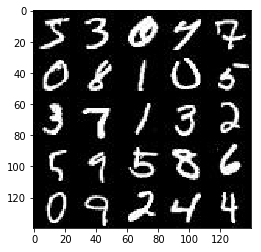

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

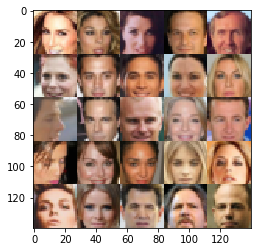

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [11]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real= tf.placeholder(tf.float32, 
                                (None,image_width, image_height, image_channels), 
                                name='input_real')
    inputs_z= tf.placeholder(tf.float32, 
                             (None, z_dim), 
                             name='input_z')
    learning_rate= tf.placeholder(tf.float32, shape=(), name='learning_rate')
    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        #Convolution w/ batch norm & leaky relu 
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        #Convolution w/ batch norm & leaky relu 
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        #Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [92]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        #Fully Connected
        x1 = tf.layers.dense(z, 7*7*512)
        
        #Reshape
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x512
        
        #Convolutional transpose w/ batch norm & leaky relu
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #7x7x256
        
        #Convolutional transpose w/ batch norm & leaky relu
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [28]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [93]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_batch=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    height = data_shape[1]
    width = data_shape[2]
    depth = data_shape[3]
    
    input_real, input_z, lr = model_inputs(height, width, depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    samples, losses = [], []
    steps = 0
            
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_batch == 0:
                    img = show_generator_output(sess, 25, input_z, depth, data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7458... Generator Loss: 0.9692
Epoch 1/2... Discriminator Loss: 0.2244... Generator Loss: 2.0505
Epoch 1/2... Discriminator Loss: 0.2275... Generator Loss: 2.0403
Epoch 1/2... Discriminator Loss: 0.2034... Generator Loss: 2.2128
Epoch 1/2... Discriminator Loss: 0.4217... Generator Loss: 1.3718
Epoch 1/2... Discriminator Loss: 0.1176... Generator Loss: 3.0044
Epoch 1/2... Discriminator Loss: 0.0513... Generator Loss: 3.8550
Epoch 1/2... Discriminator Loss: 0.0362... Generator Loss: 4.1631
Epoch 1/2... Discriminator Loss: 0.0187... Generator Loss: 4.6179
Epoch 1/2... Discriminator Loss: 0.0202... Generator Loss: 4.5662


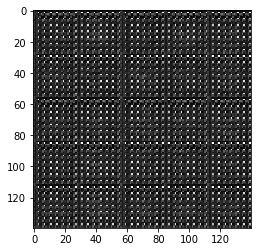

Epoch 1/2... Discriminator Loss: 0.0137... Generator Loss: 4.9113
Epoch 1/2... Discriminator Loss: 0.0109... Generator Loss: 5.1244
Epoch 1/2... Discriminator Loss: 0.0113... Generator Loss: 4.9457
Epoch 1/2... Discriminator Loss: 0.0084... Generator Loss: 5.1983
Epoch 1/2... Discriminator Loss: 0.0069... Generator Loss: 5.4809
Epoch 1/2... Discriminator Loss: 0.0058... Generator Loss: 5.6279
Epoch 1/2... Discriminator Loss: 0.0367... Generator Loss: 3.7086
Epoch 1/2... Discriminator Loss: 0.0552... Generator Loss: 3.6127
Epoch 1/2... Discriminator Loss: 3.1364... Generator Loss: 0.0678
Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 2.3544


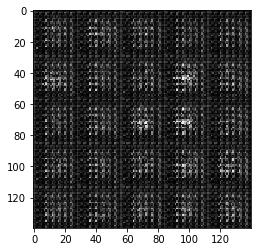

Epoch 1/2... Discriminator Loss: 1.2425... Generator Loss: 0.4885
Epoch 1/2... Discriminator Loss: 1.0190... Generator Loss: 3.8041
Epoch 1/2... Discriminator Loss: 0.6642... Generator Loss: 1.6157
Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 2.0132
Epoch 2/2... Discriminator Loss: 1.0978... Generator Loss: 1.3305
Epoch 2/2... Discriminator Loss: 0.9942... Generator Loss: 1.4344
Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 0.5430
Epoch 2/2... Discriminator Loss: 0.8055... Generator Loss: 1.0207
Epoch 2/2... Discriminator Loss: 0.9563... Generator Loss: 1.8027
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 1.8926


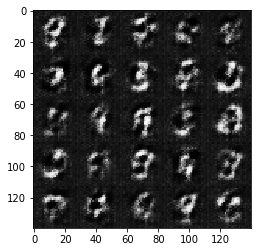

Epoch 2/2... Discriminator Loss: 0.8087... Generator Loss: 1.3833
Epoch 2/2... Discriminator Loss: 0.9359... Generator Loss: 1.9205
Epoch 2/2... Discriminator Loss: 0.7050... Generator Loss: 1.5887
Epoch 2/2... Discriminator Loss: 0.6832... Generator Loss: 1.3891
Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.3712
Epoch 2/2... Discriminator Loss: 0.6125... Generator Loss: 1.5141
Epoch 2/2... Discriminator Loss: 0.6851... Generator Loss: 1.5191
Epoch 2/2... Discriminator Loss: 0.6881... Generator Loss: 1.0803
Epoch 2/2... Discriminator Loss: 0.7025... Generator Loss: 1.3921
Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 2.6546


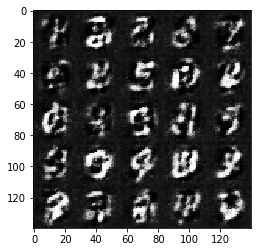

Epoch 2/2... Discriminator Loss: 0.6262... Generator Loss: 1.1851
Epoch 2/2... Discriminator Loss: 0.6017... Generator Loss: 2.0230
Epoch 2/2... Discriminator Loss: 0.8131... Generator Loss: 2.7319
Epoch 2/2... Discriminator Loss: 0.5753... Generator Loss: 2.0175
Epoch 2/2... Discriminator Loss: 0.5458... Generator Loss: 2.1999
Epoch 2/2... Discriminator Loss: 0.7127... Generator Loss: 2.1886


In [98]:
batch_size = 256
z_dim = 100
learning_rate = 0.0001
alpha=0.2
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
tf.reset_default_graph()

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 0.7157... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 2.0756... Generator Loss: 0.1693
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 4.7470
Epoch 1/1... Discriminator Loss: 1.7668... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 1.2708


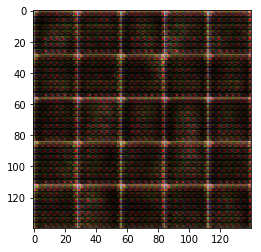

Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 1.4058
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 1.2847
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.5465... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.4127
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 1.1682


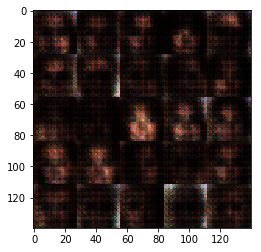

Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.5508... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.5770... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6210


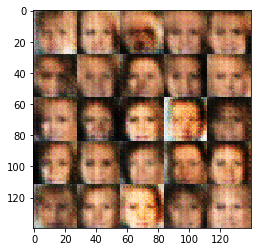

Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.5691


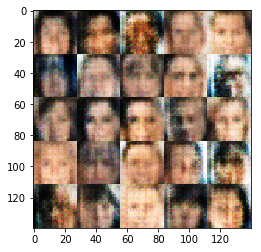

Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.6605... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.6652


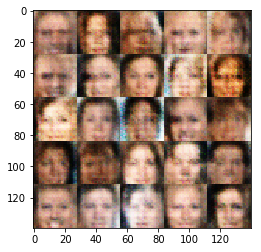

Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7155


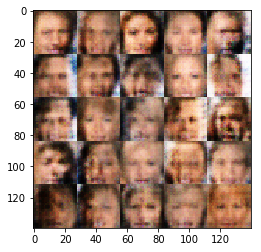

Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.8138


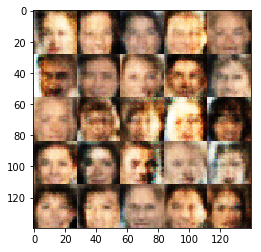

Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8300


KeyboardInterrupt: 

In [100]:
batch_size = 256
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.